## What is sequence-to-sequence learning?

- Sequence-to-sequence learning (Seq2Seq) is about training models to convert sequences from one domain (e.g. sentences in English) to sequences in another domain (e.g. the same sentences translated to French).

## Example :

 - "the cat sat on the mat" -> [Seq2Seq model] -> "le chat etait assis sur le tapis"

- This can be used for machine translation or for free-from question answering (generating a natural language answer given a natural language question) -- in general, it is applicable any time you need to generate text.

- There are multiple ways to handle this task, either using RNNs or using 1D convnets. Here we will focus on RNNs.

- The trivial case: when input and output sequences have the same length

- When both input sequences and output sequences have the same length, you can implement such models simply with a Keras LSTM or GRU layer (or stack thereof). This is the case in this that shows how to teach a RNN to learn to add numbers, encoded as character strings:

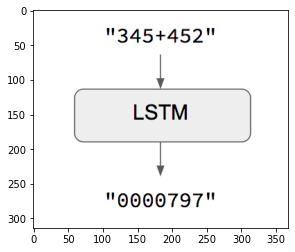

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
image = mpimg.imread('addition-rnn.png')
plt.imshow(image)
plt.show()

- One caveat of this approach is that it assumes that it is possible to generate target[...t] given input[...t]. That works in some cases (e.g. adding strings of digits) but does not work for most use cases. In the general case, information about the entire input sequence is necessary in order to start generating the target sequence.

- The general case: canonical sequence-to-sequence

- In the general case, input sequences and output sequences have different lengths (e.g. machine translation) and the entire input sequence is required in order to start predicting the target. This requires a more advanced setup, which is what people commonly refer to when mentioning "sequence to sequence models" with no further context. Here's how it works:

- A RNN layer (or stack thereof) acts as "encoder": it processes the input sequence and returns its own internal state. Note that we discard the outputs of the encoder RNN, only recovering the state. This state will serve as the "context", or "conditioning", of the decoder in the next step.

- Another RNN layer (or stack thereof) acts as "decoder": it is trained to predict the next characters of the target sequence, given previous characters of the target sequence. Specifically, it is trained to turn the target sequences into the same sequences but offset by one timestep in the future, a training process called "teacher forcing" in this context. Importantly, the encoder uses as initial state the state vectors from the encoder, which is how the decoder obtains information about what it is supposed to generate. Effectively, the decoder learns to generate targets[t+1...] given targets[...t], conditioned on the input sequence.

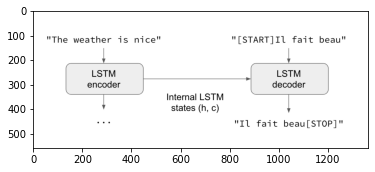

In [2]:
image = mpimg.imread('seq2seq-teacher-forcing.png')
plt.imshow(image)
plt.show()

## In inference mode, i.e. when we want to decode unknown input sequences, we go through a slightly different process:

- 1) Encode the input sequence into state vectors.

- 2) Start with a target sequence of size 1 (just the start-of-sequence character).

- 3) Feed the state vectors and 1-char target sequence to the decoder to produce predictions for the next character.

- 4) Sample the next character using these predictions (we simply use argmax).

- 5) Append the sampled character to the target sequence

- 6) Repeat until we generate the end-of-sequence character or we hit the character limit.

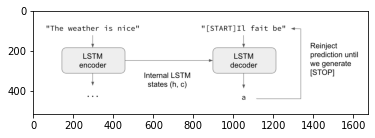

In [3]:
image = mpimg.imread('seq2seq-inference.png')
plt.imshow(image)
plt.show()

- The same process can also be used to train a Seq2Seq network without "teacher forcing", i.e. by reinjecting the decoder's predictions into the decoder.

## Let's illustrate these ideas with actual code.

- we will use a dataset of pairs of English sentences and their French translation.

- We will implement a character-level sequence-to-sequence model, processing the input character-by-character and generating the output character-by-character.

- Another option would be a word-level model, which tends to be more common for machine translation.

- At the end of this post, you will find some notes about turning our model into a word-level model using Embedding layers.

## Objective:

- Demonstrates how to implement a basic character-level recurrent sequence-to-sequence model. 

- We apply it to translating short English sentences into short French sentences,character-by-character. 

- Note that it is fairly unusual to do character-level machine translation, as word-level models are more common in this domain.


**Summary of the algorithm:**

- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).

- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).

- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.

- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    
    - Sample the next character using these predictions
        (we simply use argmax).
    
    - Append the sampled character to the target sequence
    
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.

## Here's a summary of our process:

- 1) Turn the sentences into 3 Numpy arrays, encoder_input_data, decoder_input_data, decoder_target_data:

    - encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.
    
    - decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the French sentences.
    
    - decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].

- 2) Train a basic LSTM-based Seq2Seq model to predict decoder_target_data given encoder_input_data and decoder_input_data. Our model uses teacher forcing.

- 3) Decode some sentences to check that the model is working (i.e. turn samples from encoder_input_data into corresponding samples from decoder_target_data).

- Because the training process and inference process (decoding sentences) are quite different, we use different models for both, albeit they all leverage the same inner layers.

- This is our training model. It leverages three key features of Keras RNNs:

- The return_state contructor argument, configuring a RNN layer to return a list where the first entry is the outputs and the next entries are the internal RNN states. This is used to recover the states of the encoder.

- The inital_state call argument, specifying the initial state(s) of a RNN. This is used to pass the encoder states to the decoder as initial states.

- The return_sequences constructor argument, configuring a RNN to return its full sequence of outputs (instead of just the last output, which the defaults behavior). This is used in the decoder.

# SET UP :

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense
import numpy as np
batch_size=64 #Batch size for training
epochs=100 #Number of epochs to train for
latent_dim=256 #Latent Dimensionality of the encoding Space
num_samples=10000 #Number of Samples to train on
#Path to the data txt file on disk
data_path='/fra.txt'

# PREPARING THE DATA : 

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [4]:
print(len(input_texts))

10000


In [5]:
print(len(input_characters))

71


In [6]:
target_texts #'\n ' is used to indicate the end of the sentences.
print(len(target_texts))

10000


In [7]:
target_characters
print(len(target_characters))

93


In [8]:
target_token_index

{'\t': 0,
 '\n': 1,
 ' ': 2,
 '!': 3,
 '$': 4,
 '%': 5,
 '&': 6,
 "'": 7,
 '(': 8,
 ')': 9,
 ',': 10,
 '-': 11,
 '.': 12,
 '0': 13,
 '1': 14,
 '2': 15,
 '3': 16,
 '5': 17,
 '8': 18,
 '9': 19,
 ':': 20,
 '?': 21,
 'A': 22,
 'B': 23,
 'C': 24,
 'D': 25,
 'E': 26,
 'F': 27,
 'G': 28,
 'H': 29,
 'I': 30,
 'J': 31,
 'K': 32,
 'L': 33,
 'M': 34,
 'N': 35,
 'O': 36,
 'P': 37,
 'Q': 38,
 'R': 39,
 'S': 40,
 'T': 41,
 'U': 42,
 'V': 43,
 'Y': 44,
 'a': 45,
 'b': 46,
 'c': 47,
 'd': 48,
 'e': 49,
 'f': 50,
 'g': 51,
 'h': 52,
 'i': 53,
 'j': 54,
 'k': 55,
 'l': 56,
 'm': 57,
 'n': 58,
 'o': 59,
 'p': 60,
 'q': 61,
 'r': 62,
 's': 63,
 't': 64,
 'u': 65,
 'v': 66,
 'x': 67,
 'y': 68,
 'z': 69,
 '\xa0': 70,
 '«': 71,
 '»': 72,
 'À': 73,
 'Ç': 74,
 'É': 75,
 'Ê': 76,
 'à': 77,
 'â': 78,
 'ç': 79,
 'è': 80,
 'é': 81,
 'ê': 82,
 'ë': 83,
 'î': 84,
 'ï': 85,
 'ô': 86,
 'ù': 87,
 'û': 88,
 'œ': 89,
 '\u2009': 90,
 '’': 91,
 '\u202f': 92}

In [9]:
input_token_index

{' ': 0,
 '!': 1,
 '$': 2,
 '%': 3,
 '&': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '0': 9,
 '1': 10,
 '2': 11,
 '3': 12,
 '5': 13,
 '6': 14,
 '7': 15,
 '8': 16,
 '9': 17,
 ':': 18,
 '?': 19,
 'A': 20,
 'B': 21,
 'C': 22,
 'D': 23,
 'E': 24,
 'F': 25,
 'G': 26,
 'H': 27,
 'I': 28,
 'J': 29,
 'K': 30,
 'L': 31,
 'M': 32,
 'N': 33,
 'O': 34,
 'P': 35,
 'Q': 36,
 'R': 37,
 'S': 38,
 'T': 39,
 'U': 40,
 'V': 41,
 'W': 42,
 'Y': 43,
 'a': 44,
 'b': 45,
 'c': 46,
 'd': 47,
 'e': 48,
 'f': 49,
 'g': 50,
 'h': 51,
 'i': 52,
 'j': 53,
 'k': 54,
 'l': 55,
 'm': 56,
 'n': 57,
 'o': 58,
 'p': 59,
 'q': 60,
 'r': 61,
 's': 62,
 't': 63,
 'u': 64,
 'v': 65,
 'w': 66,
 'x': 67,
 'y': 68,
 'z': 69,
 'é': 70}

In [10]:
input_texts

['Go.',
 'Hi.',
 'Hi.',
 'Run!',
 'Run!',
 'Who?',
 'Wow!',
 'Fire!',
 'Help!',
 'Jump.',
 'Stop!',
 'Stop!',
 'Stop!',
 'Wait!',
 'Wait!',
 'Go on.',
 'Go on.',
 'Go on.',
 'Hello!',
 'Hello!',
 'I see.',
 'I try.',
 'I won!',
 'I won!',
 'I won.',
 'Oh no!',
 'Attack!',
 'Attack!',
 'Cheers!',
 'Cheers!',
 'Cheers!',
 'Cheers!',
 'Get up.',
 'Go now.',
 'Go now.',
 'Go now.',
 'Got it!',
 'Got it!',
 'Got it?',
 'Got it?',
 'Got it?',
 'Hop in.',
 'Hop in.',
 'Hug me.',
 'Hug me.',
 'I fell.',
 'I fell.',
 'I fled.',
 'I know.',
 'I left.',
 'I left.',
 'I lied.',
 'I lost.',
 'I paid.',
 "I'm 19.",
 "I'm OK.",
 "I'm OK.",
 'Listen.',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'Really?',
 'Really?',
 'Really?',
 'Thanks.',
 'Thanks.',
 'We try.',
 'We won.',
 'We won.',
 'We won.',
 'We won.',
 'Ask Tom.',
 'Awesome!',
 'Be calm.',
 'Be calm.',
 'Be calm.',
 'Be cool.',
 'Be fair.',
 'Be fair.',
 'Be fair.',
 'Be fair.

In [11]:
encoder_input_data[0].shape

(15, 71)

In [12]:
# Building the model
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Training the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 47s 377ms/step - loss: 1.1861 - val_loss: 1.0663
Epoch 2/100
125/125 [==============================] - 47s 375ms/step - loss: 0.8630 - val_loss: 0.8406
Epoch 3/100
125/125 [==============================] - 48s 388ms/step - loss: 0.6990 - val_loss: 0.7297
Epoch 4/100
125/125 [==============================] - 53s 422ms/step - loss: 0.6060 - val_loss: 0.6670
Epoch 5/100
125/125 [==============================] - 47s 380ms/step - loss: 0.5539 - val_loss: 0.6159
Epoch 6/100
125/125 [==============================] - 47s 379ms/step - loss: 0.5152 - val_loss: 0.5864
Epoch 7/100
125/125 [==============================] - 48s 381ms/step - loss: 0.4844 - val_loss: 0.5622
Epoch 8/100
125/125 [==============================] - 48s 383ms/step - loss: 0.4582 - val_loss: 0.5417
Epoch 9/100
125/125 [==============================] - 48s 380ms/step - loss: 0.4363 - val_loss: 0.5348
Epoch 10/100
125/125 [==============================] - 48s 382m

In [13]:
# Save model
model.save("s2s")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: s2s/assets


# Run inference (sampling):

- encode input and retrieve initial decoder state

- run one step of decoder with this initial state and a "start of sequence" token as target. Output will be the next target token.

- Repeat with the current target token and current states

In [14]:
#Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

# You can now generate decoded sentences as such :

In [15]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Hello!
Decoded sentence: Salut !

-
Input s